# Temperature Forecasting:
    Temperature forecasting using Recurrent Neural Nets applied on time-series dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany between 2009-2016.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Imports :

In [2]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import tensorflow as tf 
from tensorflow.python.client import device_lib
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())



Device mapping: no known devices.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9671354767255627043
xla_global_id: -1
]


In [4]:
from keras import models, layers 
from tensorflow.keras.optimizers import RMSprop


In [5]:
from keras import backend as K
K._get_available_gpus()

[]

In [6]:
sns.set_style('darkgrid')
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

### Exploratory analysis :

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Temperature-Forecasting/dataset/jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


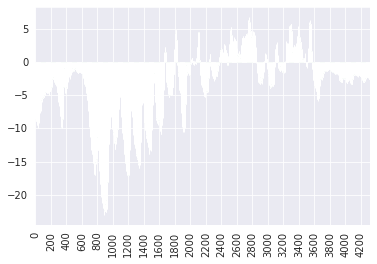

In [10]:
from matplotlib.pyplot import xticks
df["T (degC)"][:144*30].plot(kind="bar",xticks=np.arange(0,144*30,step=200), rot=90, color=sns.color_palette("deep")[2]);

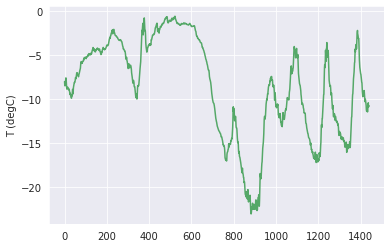

In [11]:
# data is recorded every 10 mins so 144 data point correspond to one day's recordings
# we will plot the first 10 days as a visualization of the data
plt.plot([i for i in range(144*10)], df["T (degC)"][:144*10], color = sns.color_palette("deep")[2])
plt.ylabel("T (degC)")
plt.show()

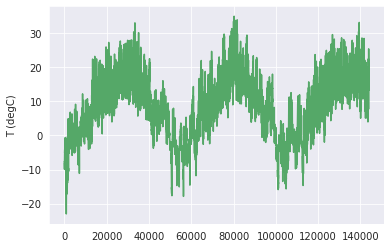

In [12]:
# we will plot the first 1000 days to get a sense of how the data behaves on the long run
plt.plot([i for i in range(144*1000)], df["T (degC)"][:144*1000], color = sns.color_palette("deep")[2])
plt.ylabel("T (degC)")
plt.show()

The chaotic nature of the temperature data can be observed

##### Showing data distribution :

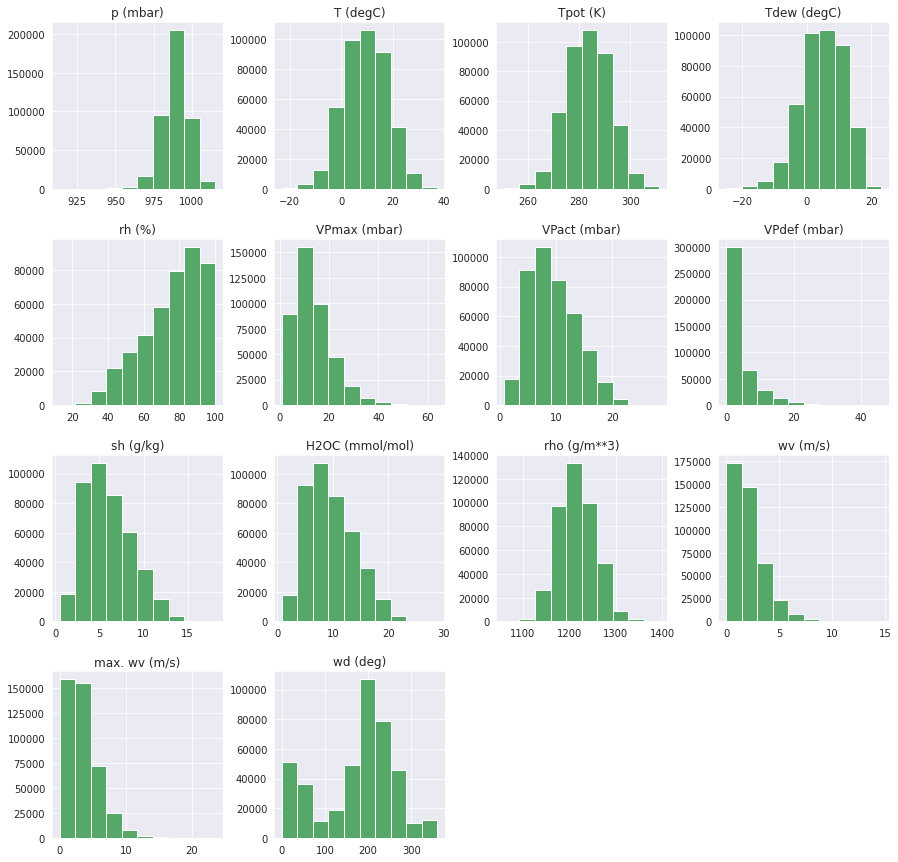

In [13]:
df.hist(figsize=(15,15), color=sns.color_palette("deep")[2]);

### Data Preparation :

In [14]:
df_normalized = df.copy()
df_normalized.drop(columns=["Date Time"], inplace=True)

In [15]:
df_normalized.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [16]:
mean = df[:200000].mean()
df_normalized -= mean 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [17]:
std = df[:200000].std()
df_normalized /= std 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [18]:
df_normalized.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.900145,-1.931354,-1.982105,-1.862796,1.072850,-1.307418,-1.473754,-0.798684,-1.476264,-1.478152,2.123745,-0.729503,-0.780678,-0.276135
1,0.906041,-1.975409,-2.025665,-1.915825,1.078828,-1.320424,-1.495192,-0.800750,-1.495021,-1.499318,2.171993,-0.931238,-0.887943,-0.463173
2,0.901324,-1.986705,-2.036834,-1.920011,1.108719,-1.323025,-1.497574,-0.802816,-1.498772,-1.501669,2.182349,-1.276140,-1.261224,-0.053306
3,0.898966,-1.964113,-2.013379,-1.886519,1.126654,-1.316522,-1.483282,-0.804882,-1.483767,-1.487559,2.157636,-1.178526,-1.317002,0.251496
4,0.898966,-1.959594,-2.010028,-1.882333,1.120676,-1.315222,-1.480900,-0.804882,-1.483767,-1.485207,2.153165,-1.191541,-1.261224,0.439689


#### Writing a generator that yields (samples, their targets) :

In [19]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data.loc[indices,:].values
            targets[j] = data.iloc[rows[j] + delay,1]
        yield samples, targets


#### Training, validation and test generators :

In [20]:
# problem constants
lookback = 1440 #10 days
step = 6        # 1 hour
delay = 144     # 1 day
batch_size = 128

In [21]:
#training generator 
train_gen = generator(df_normalized, 
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

In [22]:
val_gen = generator(df_normalized,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

In [23]:
test_gen = generator(df_normalized,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [24]:
val_steps = 300000 - 200001 - lookback
test_steps = len(df_normalized) - 300001 - lookback
val_steps = val_steps // batch_size
test_steps = test_steps // batch_size

#### Building Model :

In [25]:
model = models.Sequential()

In [26]:
model.add(layers.GRU(32, dropout=0.5, recurrent_dropout=0.5, input_shape=(None, df_normalized.shape[-1])))
model.add(layers.Dense(1))

#### Training model :

In [27]:
model.compile(optimizer=RMSprop(), loss="mae")

In [28]:
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    verbose = 1)

Epoch 1/40
500/500 [==============================] - 224s 443ms/step - loss: 0.3611 - val_loss: 0.2922
Epoch 2/40
500/500 [==============================] - 229s 458ms/step - loss: 0.3327 - val_loss: 0.2912
Epoch 3/40
500/500 [==============================] - 221s 442ms/step - loss: 0.3214 - val_loss: 0.2839
Epoch 4/40
500/500 [==============================] - 229s 458ms/step - loss: 0.3153 - val_loss: 0.2831
Epoch 5/40
500/500 [==============================] - 230s 461ms/step - loss: 0.3125 - val_loss: 0.2808
Epoch 6/40
500/500 [==============================] - 241s 482ms/step - loss: 0.3094 - val_loss: 0.2810
Epoch 7/40
500/500 [==============================] - 232s 465ms/step - loss: 0.3065 - val_loss: 0.2878
Epoch 8/40
500/500 [==============================] - 233s 466ms/step - loss: 0.3041 - val_loss: 0.2829
Epoch 9/40
500/500 [==============================] - 233s 467ms/step - loss: 0.3015 - val_loss: 0.2824
Epoch 10/40
500/500 [==============================] - 233s 466m

#### Plotting Results:

In [29]:
#plotting functions
def plot_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

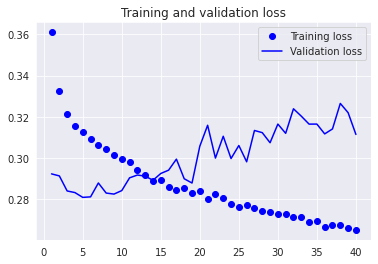

In [30]:
plot_results(history=history)

#### Saving Model:

In [32]:
model.save("./models/model.h5")